In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import ee
from datetime import datetime, date, timedelta
from omegaconf import DictConfig, OmegaConf
import pandas as pd
from rich.progress import Progress
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from util.ee_utils import (acquire_reference_date, generate_cycles,
                           get_landsat_lst, get_landsat_capture_time, load_ee_image,
                           is_landsat_pixel_clear)
from eval.surfrad import get_surfrad_surf_temp_at

In [15]:
start_date = '20140101'
end_date = '20200101'
scene_id = '016032'
config = OmegaConf.load('../config/surfrad.yaml')
lon = config.stations.PSU.Longitude
lat = config.stations.PSU.Latitude
ref_date = acquire_reference_date(start_date, scene_id)
# print('ref date =', ref_date)
cycles = generate_cycles(ref_date, end_date)
# print(cycles)
data = []
with Progress() as progress:
    task_id = progress.add_task("[cyan]Processing...", total=len(cycles))
    for date_ in cycles:
        try:
            image = load_ee_image(f'LANDSAT/LC08/C02/T1_L2/LC08_016032_{date_}')
        except ee.EEException as e:
            continue
        landsat_lst = get_landsat_lst(lon, lat, image=image)
        capture_time = get_landsat_capture_time(image=image)
        surfrad_lst = get_surfrad_surf_temp_at('PSU', capture_time)
        condition_clear = is_landsat_pixel_clear(lon, lat, image=image)
        data.append({
            'date': date_,
            'landsat_lst': landsat_lst,
            'surfrad_lst': surfrad_lst,
            'condition_clear': condition_clear,
            'delta_lst': landsat_lst - surfrad_lst
        })
        progress.update(task_id, advance=1)
df = pd.DataFrame(data)

Output()

In [16]:
df.head()

,date,landsat_lst,surfrad_lst,condition_clear,delta_lst
0,20140109,270.083359,269.557108,True,0.526250
1,20140210,264.105242,265.455015,True,-1.349774
2,20140226,249.814500,265.617119,False,-15.802619
3,20140314,279.024899,283.353920,True,-4.329021
4,20140501,267.290836,287.396323,False,-20.105487


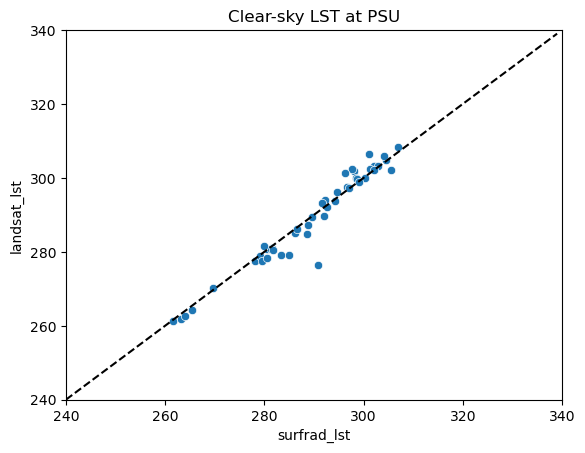

In [31]:
# Filter the DataFrame
df_filtered = df[df['condition_clear']]

# Create a scatter plot
plt.figure()
sns.scatterplot(y='landsat_lst', x='surfrad_lst', data=df_filtered)
# Add a dashed black line y = x
x = range(240, 340)
plt.plot(x, x, color='black', linestyle='--')
# Set x and y limits
plt.xlim(240, 340)
plt.ylim(240, 340)
plt.title('Clear-sky LST at PSU')
plt.show()

In [30]:
# Compute the errors
errors =  df_filtered['surfrad_lst'] - df_filtered['landsat_lst']
# Compute the RMSE
rmse = np.sqrt(mse)
# Compute the bias
bias = errors.mean()
# Compute the MAE
mae = mean_absolute_error(df_filtered['landsat_lst'], df_filtered['surfrad_lst'])
print(f"RMSE: {rmse:.2f}, Bias: {bias:.2f}, MAE: {mae:.2f}")
print('Num =', len(df_filtered))

RMSE: 3.04, Bias: 0.32, MAE: 1.89
Num = 46
